### Define utils

In [1]:
import numpy as np
import netCDF4 as nc
import glob, os
import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}
mpl.rc('font', **font)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import pandas as pd
from cmcrameri import cm
import matplotlib.transforms as transforms
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [2]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands

from utils.ppr import *
from utils import load_grid as lg

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [4]:
# pltname = "hd63433d"
# outname = "article_data/mnras_proteus_agni/hd63433d_oxfu/"
# title = "HD 63433 d"

pltname = "trappist1c"
outname = "article_data/mnras_proteus_agni/trappist1c_oxfu/"
title = "TRAPPIST-1 c"

In [5]:
folder = os.path.join(os.environ.get("HOME"),"analysis/data/", outname) + "/"

In [6]:
globber = folder + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
for f in cases:
    conf.append( read_config(f+"init_coupler.toml") )
    post.append( read_postproc(f) )

cases = lg.get_cases(folder)
helps, hvars = lg.load_helpfiles(cases)
print("Done")

/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu///case_*/
npoints = 22


Helpfiles: 100%|██████████| 22/22 [00:00<00:00, 69.31it/s]


Done


In [7]:
indep_var = "outgas.fO2_shift_IW"
indep_lbl = r"log$_{10}$ (fO$_{2}$ / IW)"

indep_vals = set()
for i in range(npoints):
    indep_vals.add(lg.descend_get(conf[i],indep_var))

indep_max = np.amax(np.abs(list(indep_vals)))
indep_unique = np.unique(list(indep_vals))


In [8]:
cmap = cm.batlow
norm = mpl.colors.Normalize(vmin=-indep_max, vmax=indep_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

In [9]:
tmps = lg.access_hvars(hvars,"T_surf",-1)

In [10]:
plt.close("all")

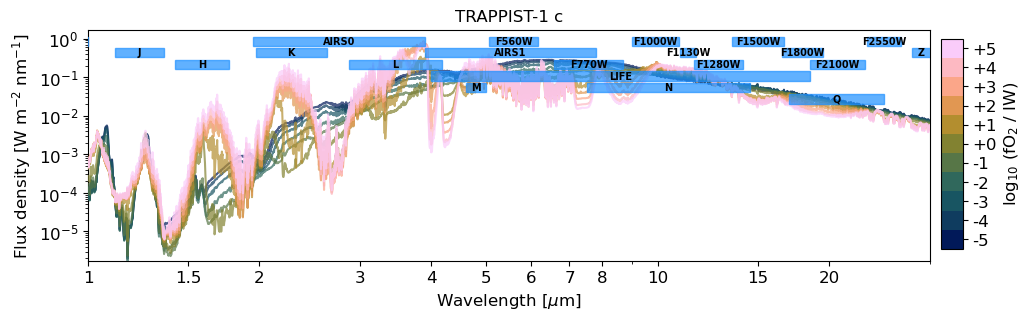

article_data/mnras_proteus_agni/trappist1c_oxfu/


In [11]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(11,3))

plot_type = "emission"
plot_planck = False
time_idx = -1
al=0.7

if plot_type == "emission":
    ylim = [1e2, 1e-5]
    xlim   = [1, 30.0]
    xticks = [1,1.5,2,3,4,5,6,7,8,  10,15,20]
    logy = True
    logx = True
    instruments = ["ARIEL", "MIRI", "LIFE", "IR"]

elif plot_type == "albedo":
    ylim = [0, 100]
    xlim = [0.3, 1.0]
    xticks = np.arange(0.3, 1.1, 0.05)
    logy = False
    logx = False
    instruments = ["VLT", "CARMENES", "GEMINI-N", "NIRISS"]

# plot emission spectra
for i in range(npoints):
    if lg.descend_get(conf[i],"atmos_clim.module") == 'janus':
        continue

    dat = post[i]
    lbl = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(float(lbl))
    ls = 'solid'

    x = np.abs(dat["bandmax"] + dat["bandmin"]) * 0.5 * 1e6
    w = np.abs(dat["bandmax"] - dat["bandmin"]) * 1e9

    if plot_type == "emission":
        y = np.abs(dat["ba_U_SW"][time_idx] + dat["ba_U_LW"][time_idx]) / w
    elif plot_type == "albedo":
        y = 100* np.abs(dat["ba_U_SW"][time_idx] / dat["ba_D_SW"][time_idx])

    # crop to observed region
    mask = np.argwhere( (x >= xlim[0]) & (x <= xlim[1]))
    x = x[mask]
    y = y[mask]
    w = w[mask]

    ylim[1] = max(ylim[1], np.amax(y[2:]))
    ylim[0] = min(ylim[0], np.amin(y[2:]))
    ax.plot(x,y,label=lbl, linestyle=ls, c=col, zorder=i*2, alpha=al)

    if plot_planck:
        x = np.logspace(np.log10(np.amin(x)-0.5),np.log10(np.amax(x)+0.5),100)
        y = np.zeros(np.shape(x))
        for j in range(len(x)):
            y[j] = planck(x[j]*1e3, tmps[i])
        ax.plot(x,y,linestyle=ls, c=col, zorder=i)

# plot instrument bandpasses
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
top  = True  # show at top?
h    = 0.04  # height of annotations
s    = 0.05 # spacing between annotations
yt   = 0.95  # axis y-pos of topmost annotation
xeps = 1.2   # delta x between annotations

if not top:
    yt = 1-yt
    s  = -s

prev_bands = []
i = -1
for ins in instruments:
    bands = observer_bands[ins]

    # for each band associated with this instrument
    for b in bands:
        v = bands[b]
        if v[0] > xlim[1]:
            continue

        i += 1

        # work out where to position this band on the plot
        if i == 0:
            y0 = yt
        else:
            for j in range(30):
                # try this y-location
                ok = True
                y0 = yt - j * s

                # check there's no overlap with other bands
                for p in prev_bands:
                    if np.isclose(p[2],y0):
                        if (p[0]< v[1] < p[1]) or (p[0] < v[0] < p[1]):
                            ok = False
                            break
                if ok:
                    break
        prev_bands.append([v[0]/xeps,v[1]*xeps,y0])
        prev_bands.append([v[0],v[1],y0])

        # band rectangle
        ax.add_patch(mpatches.Rectangle( (v[0], y0-h/2), width=v[1]-v[0], height=h,
                                        transform=trans,
                                        alpha=0.7, zorder=98, color='dodgerblue'))

        # band label
        x0 = np.sqrt(v[0]*v[1])
        if x0>xlim[1]:
            x0 = np.sqrt(v[0]*xlim[1])
        ax.text(x0, y0 , b, fontsize=7, color='k', weight='bold',
                clip_on=True, zorder=99, transform=trans,
                rotation=-0, horizontalalignment='center', verticalalignment='center')

# decorate plot
lg.add_cbar(fig, sm, ticks=indep_unique, label=indep_lbl, width=0.02)
ax.set_ylim(bottom=ylim[0], top=ylim[1]*2)
ax.set_title(title, fontsize=12)
ax.set_xlim(xlim)
if logx:
    ax.set_xscale("log")
if logy:
    ax.set_yscale("log")
ax.xaxis.set_major_formatter(FormatStrFormatter("%g"))

ax.set_xticks(xticks)
ax.set_xlabel(r"Wavelength [$\mu$m]")

ylabel = "_default"
if plot_type == "emission":
    ylabel = r"Flux density [W m$^{-2}$ nm$^{-1}$]"
elif plot_type == "albedo":
    ylabel = r"Spectral albedo [%]"
ax.set_ylabel(ylabel)

# plot and save
for fmt in ["png","pdf"]:
    fig.savefig("output/agni_v_janus/%s/%s_ppr.%s"%(pltname,plot_type,fmt),bbox_inches='tight', dpi=300)
plt.show()
print(outname)